#Migration

For modifying orbital elements, REBOUNDx offers two implementations.  `modify_orbits_direct` directly calculates orbital elements and modifies those, while `modify_orbits_forces` applies forces that when orbit-averaged yield the desired behavior.  We are currently working on a paper that considers when each one might be more appropriate.  We begin importing `rebound` and `reboundx` and setting up a simple simulation of two planets on initially eccentric and inclined orbits:

In [26]:
import rebound
import reboundx
import numpy as np
sim = rebound.Simulation()
ainner = 1.
aouter = 10.
e0 = 0.1
inc0 = 0.1

sim.add(m=1.)
sim.add(m=1e-6,a=ainner,e=e0, inc=inc0)
sim.add(m=1e-6,a=aouter,e=e0, inc=inc0)
sim.move_to_com() # Moves to the center of momentum frame

Now let's set up `reboundx` and here we choose to add `modify_orbits_forces`, which implements the migration using forces:

In [27]:
rebx = reboundx.Extras(sim)
rebx.add_modify_orbits_forces()

Both `modify_orbits_forces` and `modify_orbits_direct` have a `tau_a` member, which is an array holding the migration timescales for all the particles in the simulation.  In both cases, a non-zero `tau_a` leads to exponential decay (or growth) with timescale `tau_a`, i.e.
\begin{equation}
a = a_0e^{t/\tau_a}
\end{equation}
**Thus, negative `tau_a` values correspond to semimajor axis decay, and positive `tau_a` results in exponential growth of the semimajor axis.**

In general, each body will have different damping timescales.  The indices in the `tau_a` correspond one-to-one with those in the `particles` array in the REBOUND simulation.  A value of 0 represents no migration, and you should not make `tau_a[0]` non-zero (the central body does not have a semimajor axis to damp!).  The units of time are set by the units of time in your simulation.

**Important:** Currently you must only set damping timescales **AFTER** all the particles have been added to the simulation, and this implementation does not support adding or removing particles in the middle of the simulation (e.g. during collisions or particles leaving the box).

Let's set a maximum time for our simulation, and give our two planets different (inward) migration timescales:

In [28]:
tmax = 1.e3
tau_as = rebx.modify_orbits_forces.tau_a # nice shortcut so we don't have to keep typing the long name
tau_as[1] = -tmax/2.  # this is for particles[1]
tau_as[2] = -tmax     # this is for particles[2]

Now we simply run the simulation like we would normally with REBOUND.  Here we store the semimajor axes at 1000 equally spaced intervals:

In [29]:
Nout = 1000
a1,a2 = np.zeros(Nout), np.zeros(Nout)
times = np.linspace(0.,tmax,Nout)
for i,time in enumerate(times):
    sim.integrate(time)
    orbits = sim.calculate_orbits() # returns an array of orbits, where the 0 element is the first *PLANET*
    a1[i] = orbits[0].a
    a2[i] = orbits[1].a

Now let's plot it on a linear-log scale to check whether we get the expected exponential behavior.  We'll also overplot the expected exponential decays for comparison.

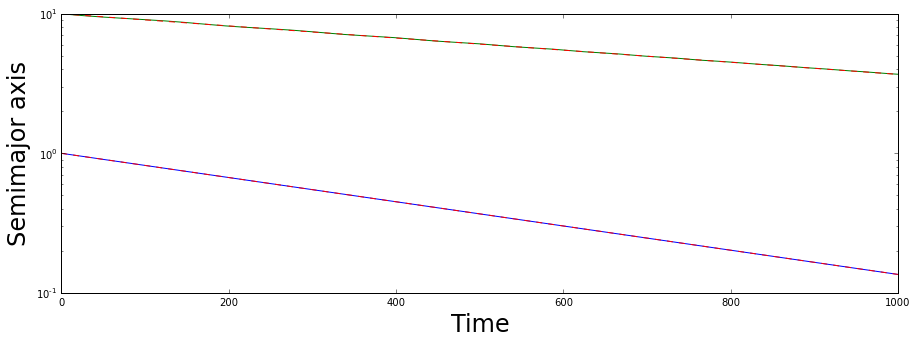

In [33]:
a1pred = [ainner*np.e**(t/tau_as[1]) for t in times]
a2pred = [aouter*np.e**(t/tau_as[2]) for t in times]

%matplotlib inline
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(15,5))
ax = plt.subplot(111)
ax.set_yscale('log')
plt.plot(times,a1)
plt.plot(times,a2)
plt.plot(times,a1pred, 'r--')
plt.plot(times,a2pred, 'r--')
plt.axes().set_xlabel("Time", fontsize=24)
plt.axes().set_ylabel("Semimajor axis", fontsize=24)